# Import and variable definition

In [1]:
import os
import csv
import math
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from skimage import io, transform
from skimage.color import rgba2rgb
from collections import OrderedDict
from kymatio import Scattering2D
import kymatio.datasets as scattering_datasets
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

TRAIN = 'train'
VAL = 'val'
PRED = 'pred'

use_cuda = True
device = torch.device('cuda' if use_cuda else 'cpu')
print ('Using GPU:', use_cuda)

Using GPU: True


# Load images and labels, preprocessing, and convert to DataFrame

In [2]:
# get painting labels
labels = {}

with open('Project1-Raphael/label.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='.')
    for row in csv_reader:
        labels[row[0]] = row[1].strip()


# load images of painting and construct into dataframe
image_extensions = ['.TIF', '.tif', '.tiff', '.jpg']
data_set = []

for file in os.listdir('Project1-Raphael'):
    extension = os.path.splitext(file)[1]
    
    if extension in image_extensions:
        
        filename = os.path.splitext(file)[0]
        image = io.imread(os.path.join('Project1-Raphael', file))
        if image.shape[2] == 4:
            image = rgba2rgb(image)
        image = np.array(image)
        if image.max() <= 1:
            image = (image * 255).astype(np.uint8)
        if image.max() > 255:
            image = (image / 255).astype(np.uint8)
        else:
            image_id = filename.split(' ')[0].replace('.', '')
            label = labels[image_id]

            if label == 'Raphael':
                data_set.append({'Image': image, 'Disputed': 0, 'Raphael': 1, 'ID':image_id})
            elif label == 'Not Raphael':
                data_set.append({'Image': image, 'Disputed': 0, 'Raphael': 0, 'ID':image_id})
            else:
                data_set.append({'Image': image, 'Disputed': 1, 'Raphael': -1, 'ID':image_id})

df = pd.DataFrame(data_set)
training_df = df[df['Disputed'] == 0]
validation_df = df[df['Disputed'] == 0]
prediction_df = df[df['Disputed'] == 1]
dataframes = {'train': training_df, 'val': training_df, 'pred':prediction_df}

# Define dataloader

In [3]:
class RaphaelPaintingsDataset(Dataset):

    def __init__(self, df, transform=None):
        """
        Args:
            df (DataFrame): A dataframe containing painting image and painted by Raphael label.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        
        self.image = df['Image'].values
        self.raphael = df['Raphael'].values
        self.data_id = df['ID'].values
        self.transform = transform

    def __len__(self):
        return len(self.raphael)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = Image.fromarray(self.image[idx])
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.raphael[idx], dtype=torch.int64)
        data_id = self.data_id[idx]
        
        sample = {'image': image, 'label': label, 'id': data_id}
        return sample
    

data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize(512),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    PRED: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
}

datasets = {
    x: RaphaelPaintingsDataset(dataframes[x], data_transforms[x])
    for x in [TRAIN, VAL, PRED]
}

dataloaders = {
    x: torch.utils.data.DataLoader(datasets[x], batch_size=12, shuffle=True, num_workers=2)
    for x in [TRAIN, VAL, PRED]
}

# Define train and validate function

In [4]:
def train(model, device, train_loader, optimizer, scattering=None):
    model.train()
    train_loss = 0
    train_accuracy = 0
    
    for samples in train_loader:
        images, labels = samples['image'], samples['label']
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        if scattering:
            output = model(scattering(images))
        else:
            output = model.forward(images)
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        train_accuracy += equality.type(torch.FloatTensor).mean()
        
    return train_loss, train_accuracy
        
def validate(model, device, validate_loader, scattering=None):
    model.eval()
    validate_loss = 0
    validate_accuracy = 0
    
    with torch.no_grad():
        for samples in validate_loader:
            images, labels = samples['image'], samples['label']
            images, labels = images.to(device), labels.to(device)
            
            if scattering:
                output = model(scattering(images))
            else:
                output = model.forward(images)
            
            validate_loss += criterion(output, labels).item()
            
            ps = torch.exp(output)
            equality = (labels.data == ps.max(dim=1)[1])
            validate_accuracy += equality.type(torch.FloatTensor).mean()
            
    return validate_loss, validate_accuracy

# Invariant scattering networks

In [5]:
scattering = Scattering2D(J=2, shape=(224, 224))
K = 81*3
if use_cuda:
    scattering = scattering.cuda()


class View(nn.Module):
    def __init__(self, *args):
        super(View, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(-1,*self.shape)


ScatterMLP = nn.Sequential(View(K, 56, 56),
                           nn.BatchNorm2d(K),
                           View(K*56*56),
                           nn.Linear(K*56*56, 512),
                           nn.ReLU(),
                           nn.Linear(512, 256),
                           nn.ReLU(),
                           nn.Linear(256, 2),
                           nn.LogSoftmax(dim=1))
ScatterMLP.to(device)

for m in ScatterMLP.modules():
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 2./math.sqrt(m.in_features))
        m.bias.data.zero_()


# model training
epochs = 100
criterion = nn.NLLLoss()
optimizer = optim.Adam(ScatterMLP.parameters(), lr=0.001)

for e in range(epochs):
    
    train_loss, train_accuracy = train(ScatterMLP, device, dataloaders[TRAIN], optimizer, scattering)
    validate_loss, validate_accuracy = validate(ScatterMLP, device, dataloaders[VAL], scattering) 
    
    if (e+1) % 10 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Train (Loss: {:.4f}".format(train_loss/len(dataloaders[TRAIN])),
              "Accuracy: {:.3f}".format(train_accuracy/len(dataloaders[TRAIN])),
              ")  Validate (Loss: {:.3f}".format(validate_loss/len(dataloaders[VAL])),
              "Accuracy: {:.2f}".format(validate_accuracy/len(dataloaders[VAL])),
              ")")

Epoch: 10/100..  Train (Loss: 125.1635 Accuracy: 0.875 )  Validate (Loss: 32.986 Accuracy: 0.73 )
Epoch: 20/100..  Train (Loss: 2.6660 Accuracy: 0.958 )  Validate (Loss: 15.248 Accuracy: 0.75 )
Epoch: 30/100..  Train (Loss: 107.9344 Accuracy: 0.854 )  Validate (Loss: 20.867 Accuracy: 0.79 )
Epoch: 40/100..  Train (Loss: 27.5427 Accuracy: 0.854 )  Validate (Loss: 0.000 Accuracy: 1.00 )
Epoch: 50/100..  Train (Loss: 184.1241 Accuracy: 0.792 )  Validate (Loss: 14.524 Accuracy: 0.92 )
Epoch: 60/100..  Train (Loss: 109.3516 Accuracy: 0.667 )  Validate (Loss: 0.000 Accuracy: 1.00 )
Epoch: 70/100..  Train (Loss: 201.6019 Accuracy: 0.833 )  Validate (Loss: 5.525 Accuracy: 0.96 )
Epoch: 80/100..  Train (Loss: 13.1229 Accuracy: 0.938 )  Validate (Loss: 2.105 Accuracy: 0.96 )
Epoch: 90/100..  Train (Loss: 28.8404 Accuracy: 0.896 )  Validate (Loss: 0.000 Accuracy: 1.00 )
Epoch: 100/100..  Train (Loss: 3.6168 Accuracy: 0.958 )  Validate (Loss: 0.000 Accuracy: 1.00 )


# Transfer learning using pretrained vgg19

In [6]:
# model definition
vgg19 = models.vgg19(pretrained=True)

for param in vgg19.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 1024)),
                                        ('relu1', nn.ReLU()),
                                        ('fc2', nn.Linear(1024,2)),
                                        ('output', nn.LogSoftmax(dim=1))
                                       ]))

vgg19.classifier = classifier
vgg19.to(device)


# model training
epochs = 20
criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.001)

for e in range(epochs):
    
    train_loss, train_accuracy = train(vgg19, device, dataloaders[TRAIN], optimizer)
    validate_loss, validate_accuracy = validate(vgg19, device, dataloaders[VAL]) 
            
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Train (Loss: {:.4f}".format(train_loss/len(dataloaders[TRAIN])),
          "Accuracy: {:.3f}".format(train_accuracy/len(dataloaders[TRAIN])),
          ")  Validate (Loss: {:.3f}".format(validate_loss/len(dataloaders[VAL])),
          "Accuracy: {:.2f}".format(validate_accuracy/len(dataloaders[VAL])),
          ")")

Epoch: 1/20..  Train (Loss: 4.6763 Accuracy: 0.521 )  Validate (Loss: 2.200 Accuracy: 0.56 )
Epoch: 2/20..  Train (Loss: 1.5558 Accuracy: 0.542 )  Validate (Loss: 1.006 Accuracy: 0.77 )
Epoch: 3/20..  Train (Loss: 0.6594 Accuracy: 0.708 )  Validate (Loss: 0.278 Accuracy: 0.81 )
Epoch: 4/20..  Train (Loss: 0.6684 Accuracy: 0.833 )  Validate (Loss: 1.148 Accuracy: 0.73 )
Epoch: 5/20..  Train (Loss: 0.9732 Accuracy: 0.875 )  Validate (Loss: 0.398 Accuracy: 0.88 )
Epoch: 6/20..  Train (Loss: 0.5604 Accuracy: 0.875 )  Validate (Loss: 0.032 Accuracy: 1.00 )
Epoch: 7/20..  Train (Loss: 0.3123 Accuracy: 0.896 )  Validate (Loss: 0.112 Accuracy: 0.96 )
Epoch: 8/20..  Train (Loss: 0.1642 Accuracy: 0.854 )  Validate (Loss: 0.076 Accuracy: 0.94 )
Epoch: 9/20..  Train (Loss: 0.1951 Accuracy: 0.958 )  Validate (Loss: 0.051 Accuracy: 1.00 )
Epoch: 10/20..  Train (Loss: 0.0343 Accuracy: 1.000 )  Validate (Loss: 0.111 Accuracy: 0.94 )
Epoch: 11/20..  Train (Loss: 0.2670 Accuracy: 0.958 )  Validate (Loss

# Prediction for ScatterNet and vgg19

In [7]:
def predict(model, device, predict_loader, scattering=None):
    model.eval()
    predict = {}
    
    with torch.no_grad():
        for samples in predict_loader:
            images = samples['image']
            images = images.to(device)
            
            if scattering:
                output = model(scattering(images))
            else:
                output = model.forward(images)
            
            ps = torch.exp(output).detach().cpu().numpy().astype(np.uint8)
            data_id = samples['id']
            
            for i in range(len(data_id)):
                predict[data_id[i]] = ps[i][0]
    
    predict = dict(sorted(predict.items()))
    return predict


scatter_net_predict = predict(ScatterMLP, device, dataloaders[PRED], scattering)
print ("Prediction by scattering MLP model:\n", scatter_net_predict)

vgg19_predict = predict(vgg19, device, dataloaders[PRED])
print ("Prediction by vgg16 model:\n", vgg19_predict)

Prediction by scattering MLP model:
 {'1': 0, '10': 1, '20': 1, '23': 0, '25': 0, '26': 1, '7': 1}
Prediction by vgg16 model:
 {'1': 0, '10': 0, '20': 0, '23': 0, '25': 0, '26': 0, '7': 0}


# Analysis 1

Comparing the first two feature extraction approches, the deep learning model perform much better than the scattering net model. Using transfoer learning on pretrained vgg19, we see a fast and study decrease in both traing and validation accuracy, acheaving 100% in a few epoch. Note the validation accuracy is higher than traing accuracy because with random crop and random flip, the traing set is much harder than the validation and prediction set. This is data augmentation to improve model training. In this part, we can say the deep learning model is better and should give a more accurate prediction.

# Data preprocessing for Sklearn

In [8]:
def image_resize(image):
    image = Image.fromarray(image)
    image = image.resize((224, 224))
    return np.array(image)

df['Image'] = df['Image'].map(lambda image: image_resize(image))

# Classical unsupervised learning: PCA

PCA explained in 1st dimension is 0.241330
PCA explained in 2nd dimension is 0.135560


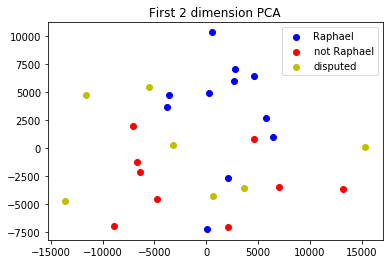

KNN prediction accuracy on the labeled set is: 0.85
2 components PCA with 3 neighbors KNN prediction:
 {'1': 1, '10': 0, '20': 1, '23': 0, '25': 0, '26': 0, '7': 0}


In [9]:
# fit 2 components PCA
pca = PCA(n_components=2)

image_set = np.array(df['Image'].values.tolist()).reshape((28,-1))
pca_image_set = pca.fit_transform(image_set)
print ("PCA explained in 1st dimension is {:f}""\nPCA explained in 2nd dimension is {:f}"
       .format(*pca.explained_variance_ratio_))


# plot data
D_1 = [pca_image_set[i, 0] for i in df.loc[df['Raphael']==1].index]
D_2 = [pca_image_set[i, 1] for i in df.loc[df['Raphael']==1].index]
raphael_scaplt = plt.scatter(x=D_1, y=D_2, color='b', label='Raphael')

D_1 = [pca_image_set[i, 0] for i in df.loc[df['Raphael']==0].index]
D_2 = [pca_image_set[i, 1] for i in df.loc[df['Raphael']==0].index]
not_raphael_sacplt = plt.scatter(x=D_1, y=D_2, color='r', label='not Raphael')

D_1 = [pca_image_set[i, 0] for i in df.loc[df['Disputed']==1].index]
D_2 = [pca_image_set[i, 1] for i in df.loc[df['Disputed']==1].index]
disputed_scaplt = plt.scatter(x=D_1, y=D_2, color='y', label='disputed')

plt.title('First 2 dimension PCA')
plt.legend(handles=[raphael_scaplt, not_raphael_sacplt, disputed_scaplt])

plt.show()


# knn model
neigh = KNeighborsClassifier(n_neighbors=3)
labeled_pca_image_set = [pca_image_set[i] for i in df.loc[df['Disputed']==0].index]
labeled_raphael_set = [df['Raphael'][i] for i in df.loc[df['Disputed']==0].index]
neigh.fit(labeled_pca_image_set, labeled_raphael_set) 

predicts = neigh.predict(labeled_pca_image_set)
incorrect_prediction_count = sum(abs(predicts - labeled_raphael_set))
accuracy = 1 - incorrect_prediction_count/len(labeled_pca_image_set)                   
print ('KNN prediction accuracy on the labeled set is:', accuracy)

disputed_pca_image_set = [pca_image_set[i] for i in df.loc[df['Disputed']==1].index]
disputed_id_set = [df['ID'][i] for i in df.loc[df['Disputed']==1].index]
predicts = neigh.predict(disputed_pca_image_set)
knn_predictions = {}
for data_id, prediction in zip(disputed_id_set, predicts):
    knn_predictions[data_id] = prediction
knn_predictions = dict(sorted(knn_predictions.items()))
print ('2 components PCA with 3 neighbors KNN prediction:\n', knn_predictions)

# Traditional supervised learning: SVM

In [10]:
clf = SVC(gamma='auto')
labeled_pca_image_set = [pca_image_set[i] for i in df.loc[df['Disputed']==0].index]
labeled_raphael_set = [df['Raphael'][i] for i in df.loc[df['Disputed']==0].index]
clf.fit(labeled_pca_image_set, labeled_raphael_set) 


predicts = clf.predict(labeled_pca_image_set)
incorrect_prediction_count = sum(abs(predicts - labeled_raphael_set))
accuracy = 1 - incorrect_prediction_count/len(labeled_pca_image_set)                   
print ('SVM prediction accuracy on the labeled set is:', accuracy)

disputed_pca_image_set = [pca_image_set[i] for i in df.loc[df['Disputed']==1].index]
disputed_id_set = [df['ID'][i] for i in df.loc[df['Disputed']==1].index]
predicts = clf.predict(disputed_pca_image_set)
knn_predictions = {}
for data_id, prediction in zip(disputed_id_set, predicts):
    knn_predictions[data_id] = prediction
knn_predictions = dict(sorted(knn_predictions.items()))
print ('SVM prediction:\n', knn_predictions)

SVM prediction accuracy on the labeled set is: 1.0
SVM prediction:
 {'1': 1, '10': 1, '20': 1, '23': 1, '25': 1, '26': 1, '7': 1}


# Analysis 2

Comparing traditional approches, we see the SVM model is doing better in the training set. This is to be expected as the 2 compoments PCA model only in total captures explained variance of less than 30%, which is not a high number for a PCA. This also represent the difference in the images may be trivial and hard to distinguish. For this SVM model, it gives an all by Raphael prediction for the disputed images. This result is being different from what vgg19 model predicts even though both have a 100% accuracy on the training set. As this being a very small dataset, with only 21 labeled datas, leave-one-out cross validation should gives us a better understanding on the actual performance of the model. However, this is a little hard to run on a PC and will not be implemented. In general, because of how data augmentation in implemented in the vgg19 model, it is much less likely to overfit than the simple SVM model. So I will say the best and most reasonable prediction in the four implemeted models is the vgg19 transfer learning model, though it does produce an all not by Raphael prediction.